# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 30)

# Read data

In [2]:
df = pd.read_csv("data/df_final_v1.csv", index_col=0)
df.head()

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,control_count,chapter_transfer,temp_date,chapter_size,chapter_retention_rate,chapter_growth_rate,industry,seat_popularity_rate,drop_date,final_palms_date,date_diff,wont_renew
0,0,31,2016-04-01,33,0,0,1,0,21,7,33,32,1,37,129784,45,0,9,0,2015-12-01,32,0.315789,1.421053,"Art, Art Framing and Products",0.076923,2016-09-14,2016-09-01,-13 days +00:00:00.000000000,0
1,2,18,2017-05-01,33,2,2,0,0,6,17,11,22,1,26,9285,1,0,9,0,2017-01-01,34,0.718750,1.093750,"Health & Wellness, Chiropractor",0.266667,NaN,2021-10-01,NaN,0
2,2,18,2018-05-01,35,1,0,0,2,6,24,19,36,1,20,7263,10,1,9,0,2018-01-01,21,0.424242,0.636364,"Health & Wellness, Chiropractor",0.210526,NaN,2021-10-01,NaN,0
3,2,18,2019-05-01,36,0,0,0,1,9,8,23,19,3,28,1860,31,2,9,0,2019-01-01,22,0.739130,1.217391,"Health & Wellness, Chiropractor",0.263158,NaN,2021-10-01,NaN,0
4,2,18,2020-05-01,33,1,0,0,3,10,13,19,47,4,30,6668,16,3,9,0,2020-01-01,26,0.760000,1.120000,"Health & Wellness, Chiropractor",0.277778,NaN,2021-10-01,NaN,0


In [3]:
df.shape

(2209, 29)

In [4]:
df.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'control_count', 'chapter_transfer', 'temp_date',
       'chapter_size', 'chapter_retention_rate', 'chapter_growth_rate',
       'industry', 'seat_popularity_rate', 'drop_date', 'final_palms_date',
       'date_diff', 'wont_renew'],
      dtype='object')

### Remove unnecessary columns
There are a couple of columns which are missing data: ```drop_date``` and ```date_diff```. There are also some columns which are left over after the data preparation phase and are unnecessary.

In [5]:
df.drop(["drop_date", "temp_date", "date_diff", "final_palms_date", "industry"], axis=1, inplace=True)

# Remove bad data
The following columns indicate member attendance rate:
- P - Present
- A - Abesent
- L - Late
- M - Medical
- S - Substitute

When those 5 columns are summed they will display a total number of meetings the member attended during the 9-month period. 

In [6]:
df["total_meetings"] = df["P"] + df["A"] + df["L"] + df["M"] + df["S"]

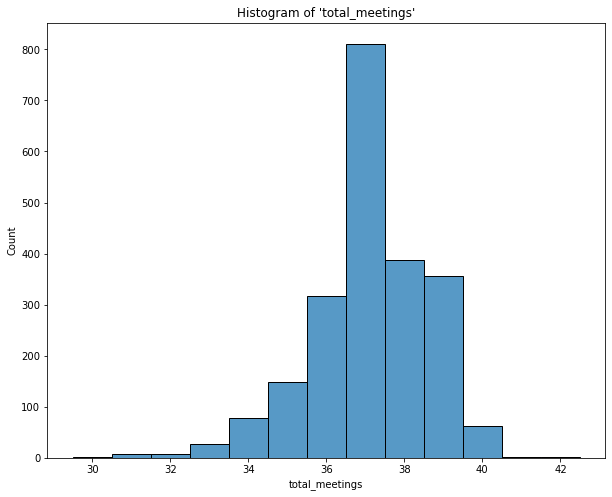

In [7]:
plt.figure(figsize=(10, 8))
sns.histplot(df["total_meetings"], discrete=True)
plt.title("Histogram of 'total_meetings'")
plt.show()

In [8]:
df["total_meetings"].value_counts().sort_index()

30      2
31      8
32      7
33     27
34     79
35    148
36    317
37    811
38    388
39    357
40     62
41      2
42      1
Name: total_meetings, dtype: int64

It is impossible for there to be more than 40 weeks during 9-month period so such records can immediately be dropped.

In [9]:
df = df.loc[df["total_meetings"] <= 40]

In [10]:
df["total_meetings"].quantile(0.05)

34.0

Lets also examine further records which are below the 0.05 quantile - less than 34 meetings. Such records are possible as there are some holidays during the year but they are unlikely and should be examined further. This can be done in comination with an imported dataset ```df_pre_agg``` which will allow to examine the data before it was aggregated into 9-month form.

### Import ```df_pre_aggregation```

In [11]:
df_pre_agg = pd.read_csv("data/df_pre_aggregation.csv", index_col=0)
df_pre_agg.head()

,user_ID,chapter_ID,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,palms_date,relative_renewal_date
0,447,9,4,0,0,0,0,1,1,0,4,0,7,0,0,2015-01-01,2015-07-01
1,1366,9,4,0,0,0,0,4,0,0,2,0,7,4975,0,2015-01-01,2015-06-01
3,1035,9,4,0,0,0,0,0,7,0,4,0,6,500,0,2015-01-01,2015-05-01
4,3035,12,1,3,0,0,0,0,1,0,0,0,0,125,0,2015-01-01,2015-07-01
8,464,23,4,0,0,0,0,3,1,0,2,1,7,735,0,2015-01-01,2015-05-01


Lets also import ```df_database``` to see when a given member joined BNI.

In [12]:
df_database = pd.read_csv("data/database_data.csv", index_col=0, encoding="ISO-8859-1")
df_database["join_date"] = pd.to_datetime(df_database["join_date"], format='%m/%d/%Y', errors='coerce')
df_database["renewal_date"] = pd.to_datetime(df_database["renewal_date"], format='%m/%d/%Y', errors='coerce')
df_database.drop(["industry", "sponsor_ID"], axis=1, inplace=True)
df_database.head()

,user_ID,chapter_ID,join_date,renewal_date
0,1034,23,2004-07-01,2010-12-01
1,909,23,2008-02-01,2008-12-01
2,2062,23,2010-09-01,2011-12-01
3,947,23,2007-03-01,2008-04-07
4,2311,23,2007-07-01,2008-07-01


The below code is used to examine records in ```df``` with less than 34 meetings. Such records will be looked up in the ```df_pre_agg``` and if there are too few meetings compared to how many meetings there should be in that 9-month period (compared to members from the same chapter and same ```relative_renewal_date```) - the record will be dropped

In [13]:
# Records to check
df.loc[df["total_meetings"] < 34, :].shape[0]

44

## Start checking process

In [14]:
# Iterate over "index" to check each record
index = 43
extra_columns = ["RGI", "RGO", "RRI", "RRO", "1-2-1", "TYFCB", "CEU","V", "year_of_membership", "chapter_size", "chapter_retention_rate", "chapter_growth_rate", "seat_popularity_rate", "control_count"]
user_ID, chapter_ID, relative_renewal_date = df.loc[df["total_meetings"] < 34, :].iloc[[index],:3].values[0]
df.drop(extra_columns, axis=1).loc[df["total_meetings"] < 34, :].iloc[[index],:]

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,chapter_transfer,wont_renew,total_meetings
2400,3052,32,2018-04-01,27,1,0,0,5,0,0,33


### Compare to other members

In [15]:
cond = (df["chapter_ID"] == chapter_ID) & (df["relative_renewal_date"] == relative_renewal_date)
df.loc[cond, ["user_ID", "chapter_ID", "relative_renewal_date", "control_count", "chapter_transfer", "total_meetings", "wont_renew"]]

,user_ID,chapter_ID,relative_renewal_date,control_count,chapter_transfer,total_meetings,wont_renew
1935,2479,32,2018-04-01,10,0,38,0
2400,3052,32,2018-04-01,9,0,33,0


### Double-check with ```df_database```

In [16]:
df_database.loc[(df_database["user_ID"] == user_ID) & (df_database["chapter_ID"] == chapter_ID)]

,user_ID,chapter_ID,join_date,renewal_date
938,3052,32,2016-04-01,2017-04-01
960,3052,32,2017-06-01,2019-06-01


In [17]:
cond = (df_pre_agg["user_ID"] == user_ID) & (df_pre_agg["chapter_ID"] == chapter_ID) & (df_pre_agg["relative_renewal_date"] == relative_renewal_date)
df_pre_agg.loc[cond, ["user_ID", "chapter_ID", "P", "A", "L", "M", "S", "palms_date", "relative_renewal_date"]]

,user_ID,chapter_ID,P,A,L,M,S,palms_date,relative_renewal_date
32569,3052,32,2,0,0,0,0,2017-04-01,2018-04-01
32661,3052,32,2,0,0,0,0,2017-05-01,2018-04-01
32765,3052,32,3,0,0,0,1,2017-06-01,2018-04-01
32874,3052,32,3,1,0,0,0,2017-07-01,2018-04-01
32980,3052,32,4,0,0,0,1,2017-08-01,2018-04-01
33092,3052,32,3,0,0,0,1,2017-09-01,2018-04-01
33199,3052,32,5,0,0,0,0,2017-10-01,2018-04-01
33302,3052,32,2,0,0,0,2,2017-11-01,2018-04-01
33405,3052,32,3,0,0,0,0,2017-12-01,2018-04-01


## Drop records from ```df```
- which have duplicated months (eg. record number 12)
- with too few meetings throughout the 9-month period (eg. member joined in 2020-01-01 but he had only one meeting that month)
- with too few meetings in relation to other members with the same renewal date and same chapter

In [18]:
index_to_drop = [12, 219, 232, 1053, 1387]
df = df.loc[~df.index.isin(index_to_drop),:]
df = df.loc[df["total_meetings"] > 31,:]
df.shape

(2192, 25)

### Check records with ```control_count``` larger than 9

In [19]:
df.loc[df["control_count"] > 9,:]

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,control_count,chapter_transfer,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,wont_renew,total_meetings
386,546,17,2018-03-01,38,0,1,0,0,1,28,1,18,8,42,3597,50,3,10,0,24,0.440000,1.000000,0.111111,0,39
684,969,18,2017-04-01,36,0,0,0,2,12,18,1,8,10,63,24515,69,0,10,1,34,0.766667,1.233333,0.533333,0,38
936,1291,6,2017-10-01,37,1,0,0,1,18,30,2,22,3,57,103723,37,1,11,0,39,0.589744,1.000000,0.176471,0,39
1066,1427,19,2017-12-01,31,1,0,0,7,15,33,3,38,6,74,5257,17,1,11,1,29,0.566667,1.133333,0.111111,0,39
1557,1987,9,2019-12-01,31,2,0,0,1,19,31,1,20,6,59,44798,35,5,10,0,38,0.743590,0.974359,0.388889,0,34
1565,1990,23,2017-02-01,36,0,0,0,0,10,25,0,30,5,61,17056,64,0,10,0,37,0.600000,1.000000,0.200000,0,36
1579,1999,31,2021-05-01,37,0,0,0,0,7,37,5,13,8,31,55397,36,8,10,0,19,0.590909,0.818182,0.090909,0,37
1773,2289,6,2019-08-01,37,0,0,0,1,16,224,4,45,8,117,383241,36,2,11,0,43,0.589744,1.435897,0.444444,0,38
1898,2440,17,2018-09-01,39,0,0,0,0,3,33,8,12,13,47,18228,21,0,10,0,21,0.428571,1.047619,0.500000,0,39
1935,2479,32,2018-04-01,33,4,0,0,1,11,2,10,11,1,10,8459,0,2,10,0,32,0.600000,0.775000,0.222222,0,38


In [20]:
# Iterate over "index" to check each record
index = 14
extra_columns = ["RGI", "RGO", "RRI", "RRO", "1-2-1", "TYFCB", "CEU","V", "year_of_membership", "chapter_size", "chapter_retention_rate", "chapter_growth_rate", "seat_popularity_rate"]
user_ID, chapter_ID, relative_renewal_date = df.loc[df["control_count"] > 9, :].iloc[[index],:3].values[0]
df.drop(extra_columns, axis=1).loc[df["control_count"] > 9, :].iloc[[index],:]

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,control_count,chapter_transfer,wont_renew,total_meetings
2396,3047,21,2021-05-01,30,2,0,3,0,10,1,0,35


### Compare to other members

In [21]:
cond = (df["chapter_ID"] == chapter_ID) & (df["relative_renewal_date"] == relative_renewal_date)
df.loc[cond, ["user_ID", "chapter_ID", "relative_renewal_date", "control_count", "chapter_transfer", "total_meetings", "control_count", "wont_renew"]]

,user_ID,chapter_ID,relative_renewal_date,control_count,chapter_transfer,total_meetings,control_count,wont_renew
2396,3047,21,2021-05-01,10,1,35,10,0


### Double-check with ```df_database```

In [22]:
df_database.loc[(df_database["user_ID"] == user_ID) & (df_database["chapter_ID"] == chapter_ID)]

,user_ID,chapter_ID,join_date,renewal_date
3133,3047,21,2020-08-01,2022-05-01


In [23]:
cond = (df_pre_agg["user_ID"] == user_ID) & (df_pre_agg["relative_renewal_date"] == relative_renewal_date)
df_pre_agg.loc[cond, ["user_ID", "chapter_ID", "P", "A", "L", "M", "S", "palms_date", "relative_renewal_date"]]

,user_ID,chapter_ID,P,A,L,M,S,palms_date,relative_renewal_date
36507,3047,19,3,1,0,0,0,2020-05-01,2021-05-01
36627,3047,19,4,0,0,0,0,2020-06-01,2021-05-01
36745,3047,19,3,1,0,0,0,2020-07-01,2021-05-01
36865,3047,19,1,0,0,1,0,2020-08-01,2021-05-01
36967,3047,21,2,0,0,0,0,2020-08-01,2021-05-01
37082,3047,21,3,0,0,1,0,2020-09-01,2021-05-01
37194,3047,21,4,0,0,0,0,2020-10-01,2021-05-01
37304,3047,21,4,0,0,0,0,2020-11-01,2021-05-01
37412,3047,21,2,0,0,1,0,2020-12-01,2021-05-01
37520,3047,21,4,0,0,0,0,2021-01-01,2021-05-01


In [24]:
index_to_drop = [936]
df = df.loc[~df.index.isin(index_to_drop),:]
df.shape

(2191, 25)

## Drop unnecessary columns

In [25]:
df.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'control_count', 'chapter_transfer',
       'chapter_size', 'chapter_retention_rate', 'chapter_growth_rate',
       'seat_popularity_rate', 'wont_renew', 'total_meetings'],
      dtype='object')

In [26]:
df.drop(["control_count", "chapter_transfer"], axis=1, inplace=True)
df.shape

(2191, 23)

In [27]:
# Rearrange columns
cols_list = df.columns.tolist()
cols_list.remove("wont_renew")
cols_list += ["wont_renew"]
df = df[cols_list]

# Explore

In [28]:
df.shape

(2191, 23)

In [29]:
df.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'chapter_size', 'chapter_retention_rate',
       'chapter_growth_rate', 'seat_popularity_rate', 'total_meetings',
       'wont_renew'],
      dtype='object')

In [30]:
df.head()

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,total_meetings,wont_renew
0,0,31,2016-04-01,33,0,0,1,0,21,7,33,32,1,37,129784,45,0,32,0.315789,1.421053,0.076923,34,0
1,2,18,2017-05-01,33,2,2,0,0,6,17,11,22,1,26,9285,1,0,34,0.718750,1.093750,0.266667,37,0
2,2,18,2018-05-01,35,1,0,0,2,6,24,19,36,1,20,7263,10,1,21,0.424242,0.636364,0.210526,38,0
3,2,18,2019-05-01,36,0,0,0,1,9,8,23,19,3,28,1860,31,2,22,0.739130,1.217391,0.263158,37,0
4,2,18,2020-05-01,33,1,0,0,3,10,13,19,47,4,30,6668,16,3,26,0.760000,1.120000,0.277778,37,0


In [31]:
df["relative_renewal_date"] = pd.to_datetime(df["relative_renewal_date"], format='%Y-%m-%d')
df["wont_renew"] = df["wont_renew"].astype("bool")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 0 to 2428
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_ID                 2191 non-null   int64         
 1   chapter_ID              2191 non-null   int64         
 2   relative_renewal_date   2191 non-null   datetime64[ns]
 3   P                       2191 non-null   int64         
 4   A                       2191 non-null   int64         
 5   L                       2191 non-null   int64         
 6   M                       2191 non-null   int64         
 7   S                       2191 non-null   int64         
 8   RGI                     2191 non-null   int64         
 9   RGO                     2191 non-null   int64         
 10  RRI                     2191 non-null   int64         
 11  RRO                     2191 non-null   int64         
 12  V                       2191 non-null   int64   

## Data balance

In [31]:
df["wont_renew"].value_counts()

0    1519
1     672
Name: wont_renew, dtype: int64

In [32]:
df["wont_renew"].value_counts() / df.shape[0]

0    0.693291
1    0.306709
Name: wont_renew, dtype: float64

Nearly 70% of the data is labelled as "0" which shows that the data is imbalanced.

## Data info

In [33]:
df.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'chapter_size', 'chapter_retention_rate',
       'chapter_growth_rate', 'seat_popularity_rate', 'total_meetings',
       'wont_renew'],
      dtype='object')

In [34]:
df[['P', 'A', 'L', 'M', 'S', 'total_meetings']].describe().iloc[1:].round(4).to_csv("data/latex_describe_attendance.csv")
df[['RGI', 'RGO', 'RRI', 'RRO']].describe().iloc[1:].round(4).to_csv("data/latex_describe_referrals.csv")
df[['V', '1-2-1', 'TYFCB', 'CEU']].describe().iloc[1:].round(4).to_csv("data/latex_describe_other.csv")
df[['year_of_membership', 'chapter_size', 'chapter_retention_rate',
       'chapter_growth_rate', 'seat_popularity_rate']].describe().iloc[1:].round(4).to_csv("data/latex_describe_created.csv")
df.iloc[1:,3:].describe()

,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,total_meetings,wont_renew
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2.190000e+03,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,33.179452,1.544292,0.373059,0.438356,1.607763,10.222374,25.257078,9.966667,24.835616,3.944292,42.684932,2.859493e+04,41.394521,1.747945,29.241553,0.654327,1.181140,0.261913,37.142922,0.306849
std,3.566664,1.833549,1.116390,1.509703,1.585693,7.412123,19.807966,11.334899,21.382129,4.021709,22.374839,7.859078e+04,41.155119,2.403445,6.561764,0.141709,0.345702,0.207204,1.429038,0.461292
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000e+00,0.000000,0.000000,10.000000,0.086957,0.575758,0.000000,32.000000,0.000000
25%,31.000000,0.000000,0.000000,0.000000,0.000000,5.000000,13.000000,3.000000,11.000000,1.000000,29.000000,5.337750e+03,19.250000,0.000000,24.000000,0.571429,1.000000,0.090909,36.000000,0.000000
50%,34.000000,1.000000,0.000000,0.000000,1.000000,9.000000,21.000000,7.000000,20.000000,3.000000,38.000000,1.245850e+04,36.000000,1.000000,30.000000,0.666667,1.111111,0.200000,37.000000,0.000000
75%,36.000000,2.000000,0.000000,0.000000,3.000000,14.000000,32.000000,12.000000,32.000000,5.000000,52.000000,2.790225e+04,50.000000,3.000000,34.000000,0.741935,1.271853,0.400000,38.000000,1.000000
max,40.000000,22.000000,15.000000,21.000000,11.000000,62.000000,224.000000,126.000000,296.000000,36.000000,276.000000,1.467394e+06,580.000000,22.000000,44.000000,1.000000,2.875000,1.000000,40.000000,1.000000


### Record counts per chapter

In [36]:
df["chapter_ID"].value_counts().to_frame("number_of_records").reset_index().rename({"index": "chapter_ID"}, axis=1).to_csv("data/latex_chapter_count.csv")

# Plots

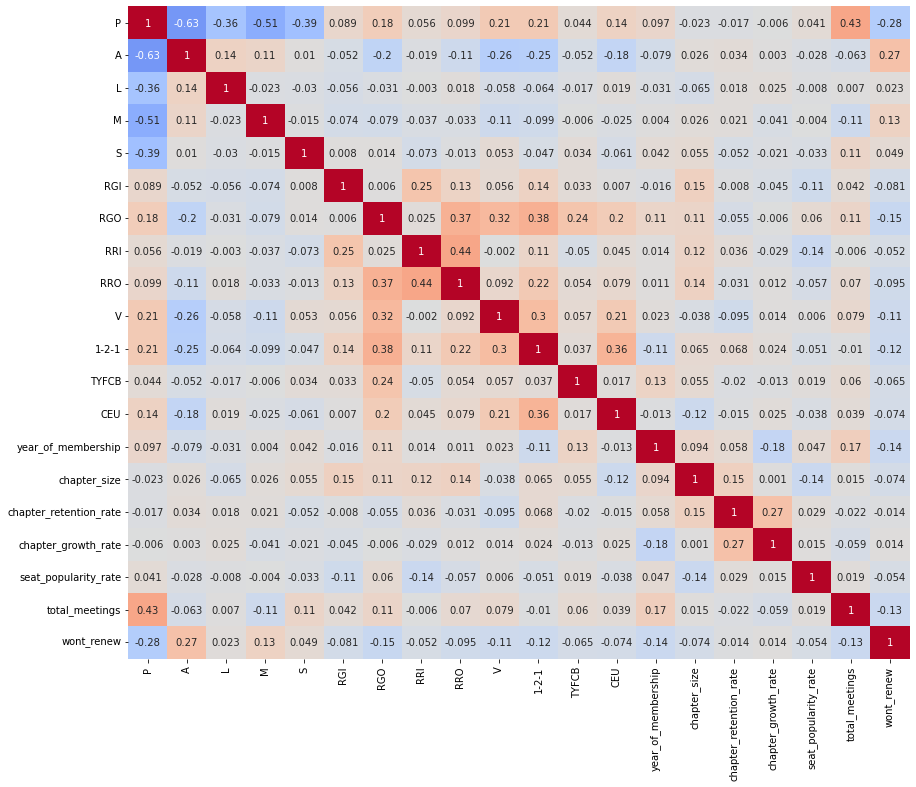

In [68]:
corr = df.iloc[:, 3:].corr().round(3)
plt.figure(figsize=(14,12))
sns.heatmap(corr, cbar=False, annot=True, fmt=".2g", vmin=-1, vmax=1, center=0, cmap="coolwarm")
# plt.title("Correlation matrix")
# plt.tight_layout()
plt.savefig('plots/correlation.png', dpi=400, bbox_inches='tight')
plt.show()

In [37]:
df.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'chapter_size', 'chapter_retention_rate',
       'chapter_growth_rate', 'seat_popularity_rate', 'total_meetings',
       'wont_renew'],
      dtype='object')

### Attendance measures (cols 4-8)

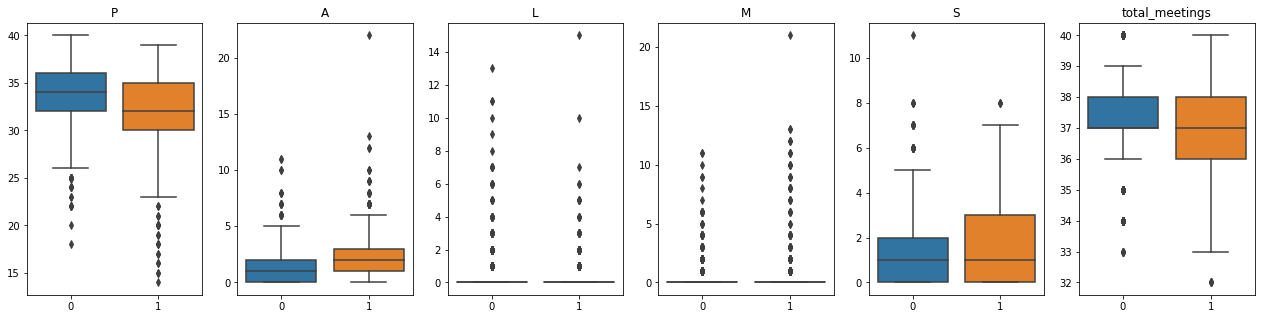

In [39]:
cols = ['P', 'A', 'L', 'M', 'S', 'total_meetings', 'wont_renew']
df_attendance = df[cols].copy()
n_plots = len(cols) - 1

fig, ax = plt.subplots(1, n_plots, figsize=(22, 5))

for i in range(n_plots):
    sns.boxplot(y=cols[i], x="wont_renew", data=df_attendance, ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].title.set_text(cols[i])
plt.savefig('plots/df_attenance_boxplots.png', dpi=400, bbox_inches='tight')
plt.show()

The **P** and **A** graphs are interesting as they seem to show a slight trend. If someone is present during more meetings, he is more likely to renew and vice-versa, if someone is more absent - he is less likely to renew.

It is also clear that there are many outliers in all of those plots. The ones which are most interesting are over 20 absences seen on the **A** boxplot and over 20 medical leaves on the **M** boxplot.

Lets explore the data further.

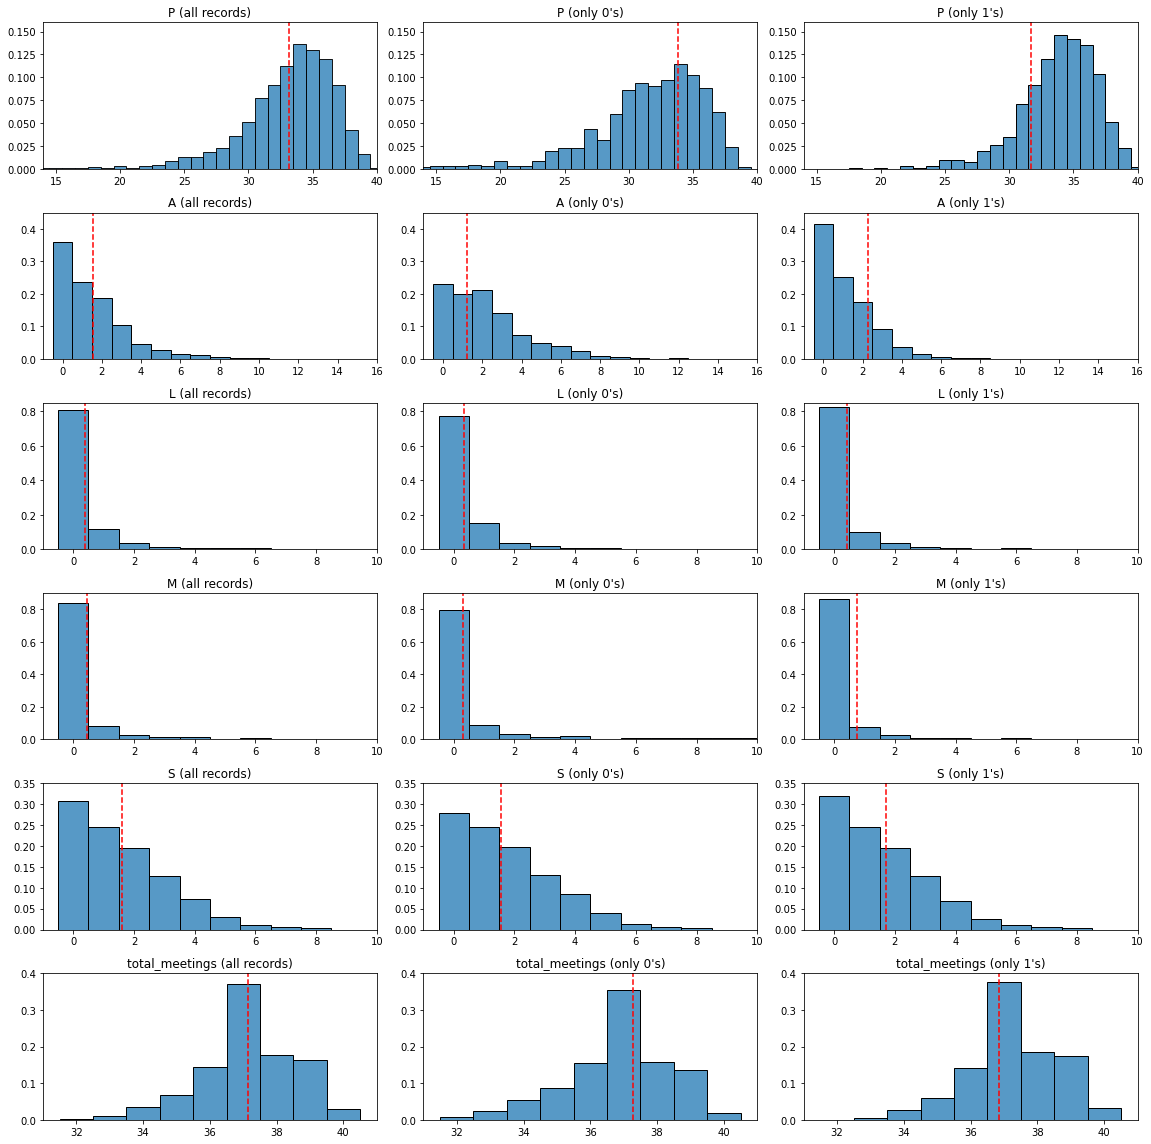

In [41]:
fig, ax = plt.subplots(n_plots, 3, figsize=(16, 16))

for i in range(n_plots):
    sns.histplot(x=cols[i], discrete=True, stat="density",data=df_attendance, ax=ax[i,0])
    ax[i,0].axvline(df_attendance[cols[i]].mean(), color="red", linestyle="--")
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,0].title.set_text(cols[i] + " (all records)")
    
    sns.histplot(x=cols[i], discrete=True, stat="density", data=df_attendance.loc[df_attendance["wont_renew"] == 1], ax=ax[i,1])
    ax[i,1].axvline(df_attendance.loc[df_attendance["wont_renew"] == 0, cols[i]].mean(), color="red", linestyle="--")
    ax[i,1].set_xlabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].title.set_text(cols[i] + " (only 0's)")
    
    sns.histplot(x=cols[i], discrete=True, stat="density", data=df_attendance.loc[df_attendance["wont_renew"] == 0], ax=ax[i,2])
    ax[i,2].axvline(df_attendance.loc[df_attendance["wont_renew"] == 1, cols[i]].mean(), color="red", linestyle="--")
    ax[i,2].set_xlabel("")
    ax[i,2].set_ylabel("")
    ax[i,2].title.set_text(cols[i] + " (only 1's)")
    

    
for i in range(3):
    ax[0,i].set_xlim([14, 40]) # P
    ax[0,i].set_ylim([0, 0.16])
    
    ax[1,i].set_xlim([-1, 16]) # A
    ax[1,i].set_ylim([0, 0.45])
    
    ax[2,i].set_xlim([-1, 10]) # L
    ax[2,i].set_ylim([0, 0.85])
    
    ax[3,i].set_xlim([-1, 10]) # M
    ax[3,i].set_ylim([0, 0.9])
    
    ax[4,i].set_xlim([-1, 10]) # S
    ax[4,i].set_ylim([0, 0.35])
    
    ax[5,i].set_xlim([31, 41]) # total
    ax[5,i].set_ylim([0, 0.4])
    
    
plt.tight_layout()
plt.savefig('plots/attendance_density.png', dpi=400, bbox_inches='tight')
plt.show()

The histograms are very similar for 1's and 0's. Both in terms of shape and they always have the same mode for each of the variables. Two observations worth mentioning are:
1. The **P (only 1's)** histogram indicates a bit heavier left tail than the **P (only 0's)** which means that members who don't intend to renew attend fewer meetings than the ones who do
2. The **A (only 1's)** histogram has three bars with very similarly large height compared to **A (only 0's)** which starts with only one high bar and then decreases. Combined with the fact that the red lines showing sample mean. The mean is visibly smaller for **P (only 1's)** than **P (only 0's)**

In [40]:
df_attendance_means = pd.concat([df_attendance.mean()[:-1],
                                 pd.pivot_table(df_attendance, columns=['wont_renew'], aggfunc='mean')],axis=1)
df_attendance_means.columns = ["all_records", "only 0's", "only 1's"]
df_attendance_means.round(2).to_csv("data/latex_means_attendance.csv")
df_attendance_means.round(2)

,all_records,only 0's,only 1's
P,33.18,33.83,31.70
A,1.54,1.22,2.28
L,0.37,0.36,0.41
M,0.44,0.30,0.74
S,1.61,1.55,1.72
total_meetings,37.14,37.27,36.86


In [44]:
def scatter_jitter(data, x, y, x_jitter=0.47, y_jitter=0.47, **kwargs):
    df_jitter = data.copy()
    x_jitter = np.random.uniform(-x_jitter, x_jitter, data.shape[0])
    y_jitter = np.random.uniform(-y_jitter, y_jitter, data.shape[0])
    
    df_jitter[x] = df_jitter[x] + x_jitter
    df_jitter[y] = df_jitter[y] + y_jitter
    
    sns.scatterplot(data=df_jitter, x=x, y=y, **kwargs)

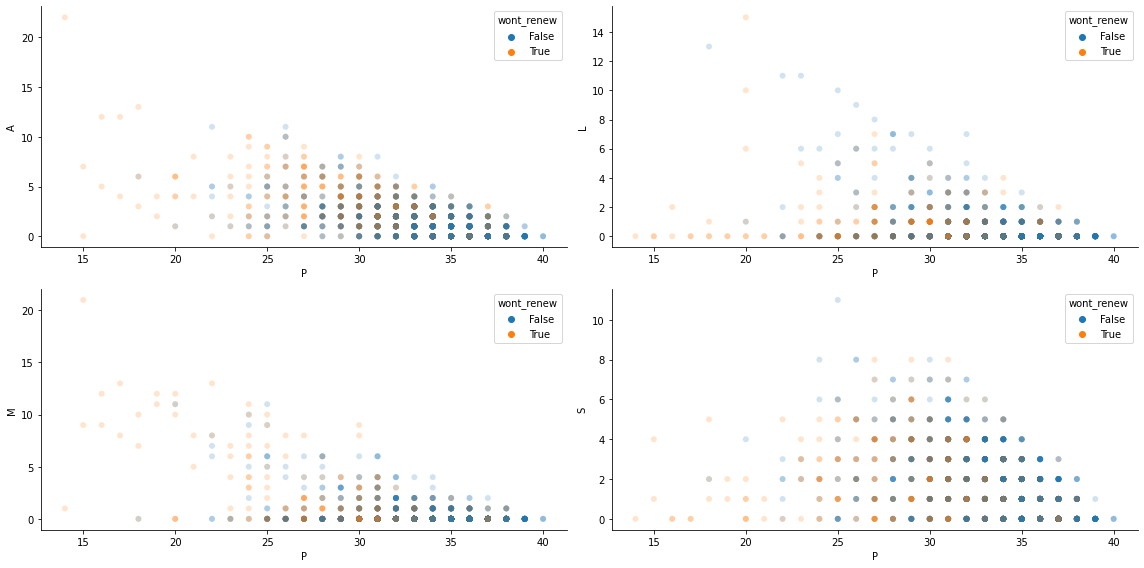

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x="P", y="A", hue="wont_renew", edgecolor='none', alpha=0.2, data=df, ax=ax[0,0])
sns.scatterplot(x="P", y="L", hue="wont_renew", edgecolor='none', alpha=0.2, data=df, ax=ax[0,1])
sns.scatterplot(x="P", y="M", hue="wont_renew", edgecolor='none', alpha=0.2, data=df, ax=ax[1,0])
sns.scatterplot(x="P", y="S", hue="wont_renew", edgecolor='none', alpha=0.2, data=df, ax=ax[1,1])
# plt.savefig('plots/attendance_scatter.png', dpi=400, bbox_inches='tight')
sns.despine()
plt.tight_layout()
plt.show()

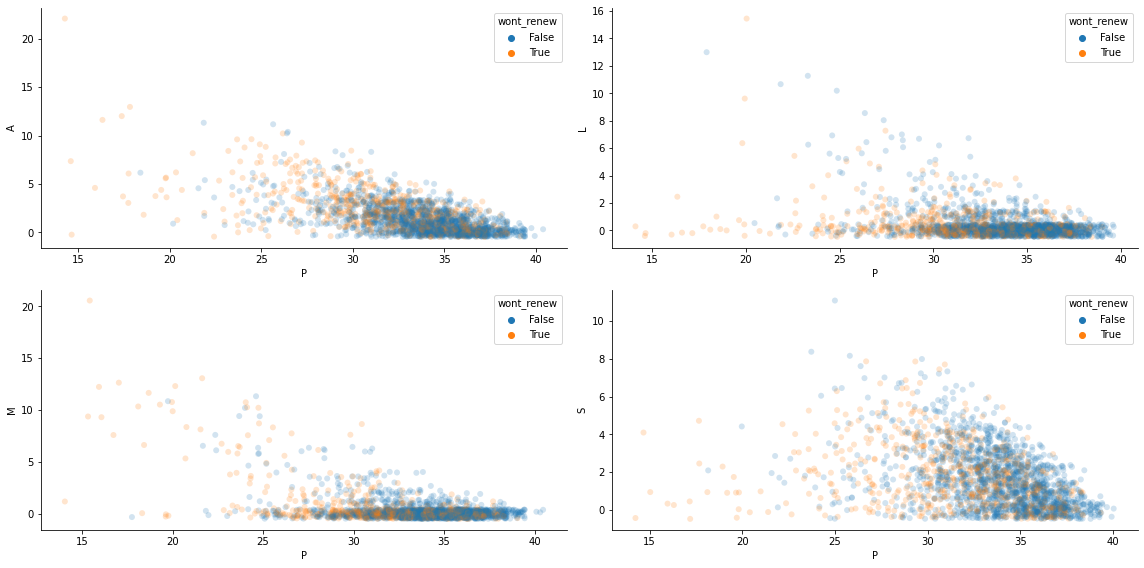

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
scatter_jitter(x="P", y="A", hue="wont_renew", sizes=[5,5], edgecolor='none', alpha=0.2, data=df, ax=ax[0,0])
scatter_jitter(x="P", y="L", hue="wont_renew", sizes=[5,5], edgecolor='none', alpha=0.2, data=df, ax=ax[0,1])
scatter_jitter(x="P", y="M", hue="wont_renew", sizes=[5,5], edgecolor='none', alpha=0.2, data=df, ax=ax[1,0])
scatter_jitter(x="P", y="S", hue="wont_renew", sizes=[5,5], edgecolor='none', alpha=0.2, data=df, ax=ax[1,1])
sns.despine()
plt.tight_layout()
plt.savefig('plots/attendance_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

#### Create extra attendance features

In [36]:
df_attendance["P_by_A"] = df_attendance["P"] / (df_attendance["A"] + 1)
df_attendance["P_by_M"] = df_attendance["P"] / (df_attendance["M"] + 1)
df_attendance["P_by_S"] = df_attendance["P"] / (df_attendance["S"] + 1)

# df_attendance["AM"] = df_attendance["A"] * df_attendance["M"]
# df_attendance["AS"] = df_attendance["A"] * df_attendance["S"]
# df_attendance["AMS"] = df_attendance["A"] * df_attendance["M"] * df_attendance["S"]
# df_attendance["A2MS"] = df_attendance["A"]**2 * df_attendance["M"] * df_attendance["S"]

# df_attendance["P_by_AM"] = df_attendance["P"] / (df_attendance["A"] + df_attendance["M"] + 1)
# df_attendance["P_by_A2M"] = df_attendance["P"] / (df_attendance["A"]**2 + df_attendance["M"] + 1)
# df_attendance["P_by_AM_2"] = df_attendance["P"] / (df_attendance["A"] + df_attendance["M"] + 1)**2
# df_attendance["P2_by_AM_2"] = df_attendance["P"]**2 / (df_attendance["A"] + df_attendance["M"] + 1)**2

# df_attendance["P_by_AS"] = df_attendance["P"] / (df_attendance["A"] + df_attendance["S"] + 1)
# df_attendance["P_by_A2S"] = df_attendance["P"] / (df_attendance["A"]**2 + df_attendance["S"] + 1)
# df_attendance["P_by_AS_2"] = df_attendance["P"] / (df_attendance["A"] + df_attendance["S"] + 1)**2
# df_attendance["P2_by_AS_2"] = df_attendance["P"]**2 / (df_attendance["A"] + df_attendance["S"] + 1)**2

# df_attendance["P_by_AMS"] = df_attendance["P"] / (df_attendance["A"] + df_attendance["M"] + df_attendance["S"] + 1)
# df_attendance["P_by_A2MS"] = df_attendance["P"] / (df_attendance["A"]**2 + df_attendance["M"] + df_attendance["S"] + 1)
# df_attendance["P_by_AMS_2"] = df_attendance["P"] / (df_attendance["A"] + df_attendance["M"] + df_attendance["S"] + 1)**2
# df_attendance["P2_by_AMS"] = df_attendance["P"]**2 / (df_attendance["A"] + df_attendance["M"] + df_attendance["S"] + 1)

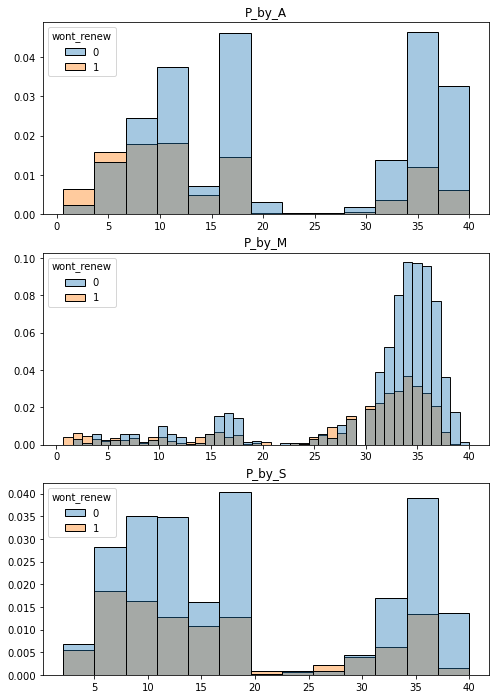

In [37]:
cols = ["P_by_A", "P_by_M", "P_by_S"]
n_plots = len(cols) 

fig, ax = plt.subplots(n_plots, 1, figsize=(8, 12))

for i in range(n_plots):
    sns.histplot(x=cols[i], hue="wont_renew", stat="density", alpha=0.4, data=df_attendance, ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].title.set_text(cols[i])
plt.show()

The **P_by_A** histogram augments the fact that members who wont renew tend to have a higher P/A ratio and thus there are more observations on the left side of the orange histogram. Unfortunately there are quite a few members who will be renewing (blue) and are also on the left side but compared the whole distribution, it seems as though there are more 

### Referral measures (columns 9-12)

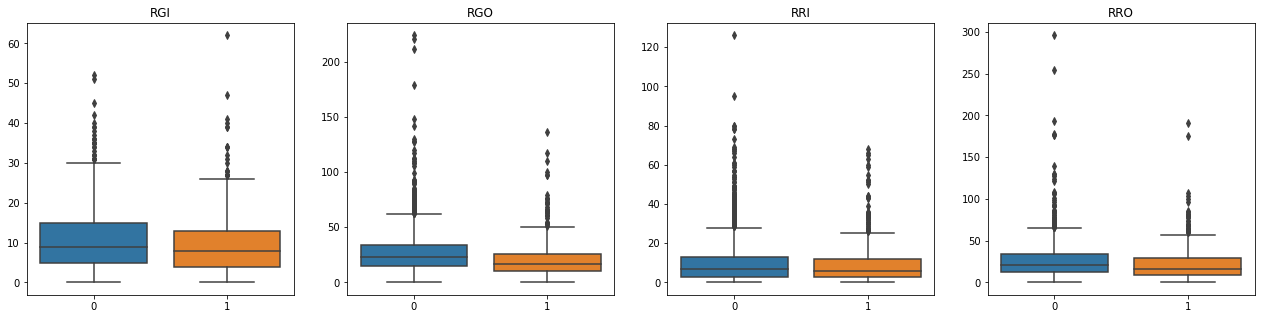

In [53]:
cols = ['RGI', 'RGO', 'RRI', 'RRO', 'wont_renew']
df_referrals = df[cols].copy()
n_plots = len(cols) - 1

fig, ax = plt.subplots(1, n_plots, figsize=(22, 5))

for i in range(n_plots):
    sns.boxplot(y=cols[i], x="wont_renew", data=df_referrals, ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].title.set_text(cols[i])
plt.savefig('plots/referrals_boxplots.png', dpi=400, bbox_inches='tight')
plt.show()

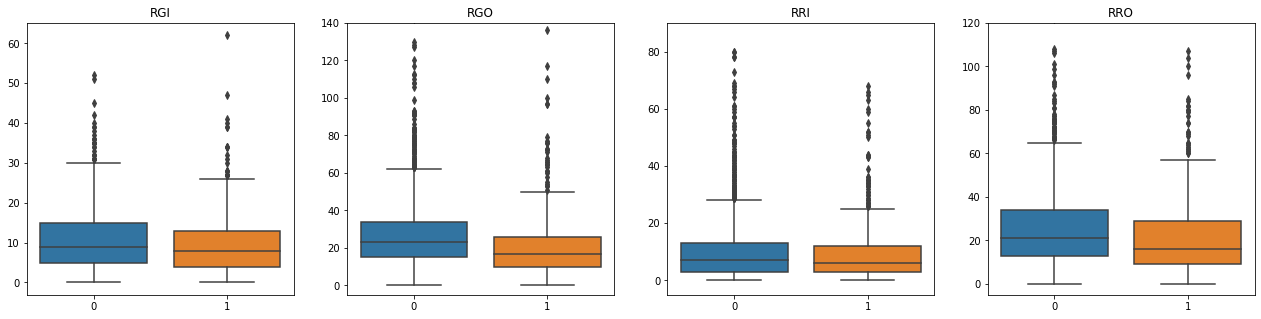

In [54]:
# Zoomed-in boxplots

fig, ax = plt.subplots(1, n_plots, figsize=(22, 5))

for i in range(n_plots):
    sns.boxplot(y=cols[i], x="wont_renew", data=df_referrals, ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].title.set_text(cols[i])

ax[1].set_ylim([-5, 140])
ax[2].set_ylim([-5, 90])
ax[3].set_ylim([-5, 120])

plt.savefig('plots/referrals_boxplots2.png', dpi=400, bbox_inches='tight')
plt.show()

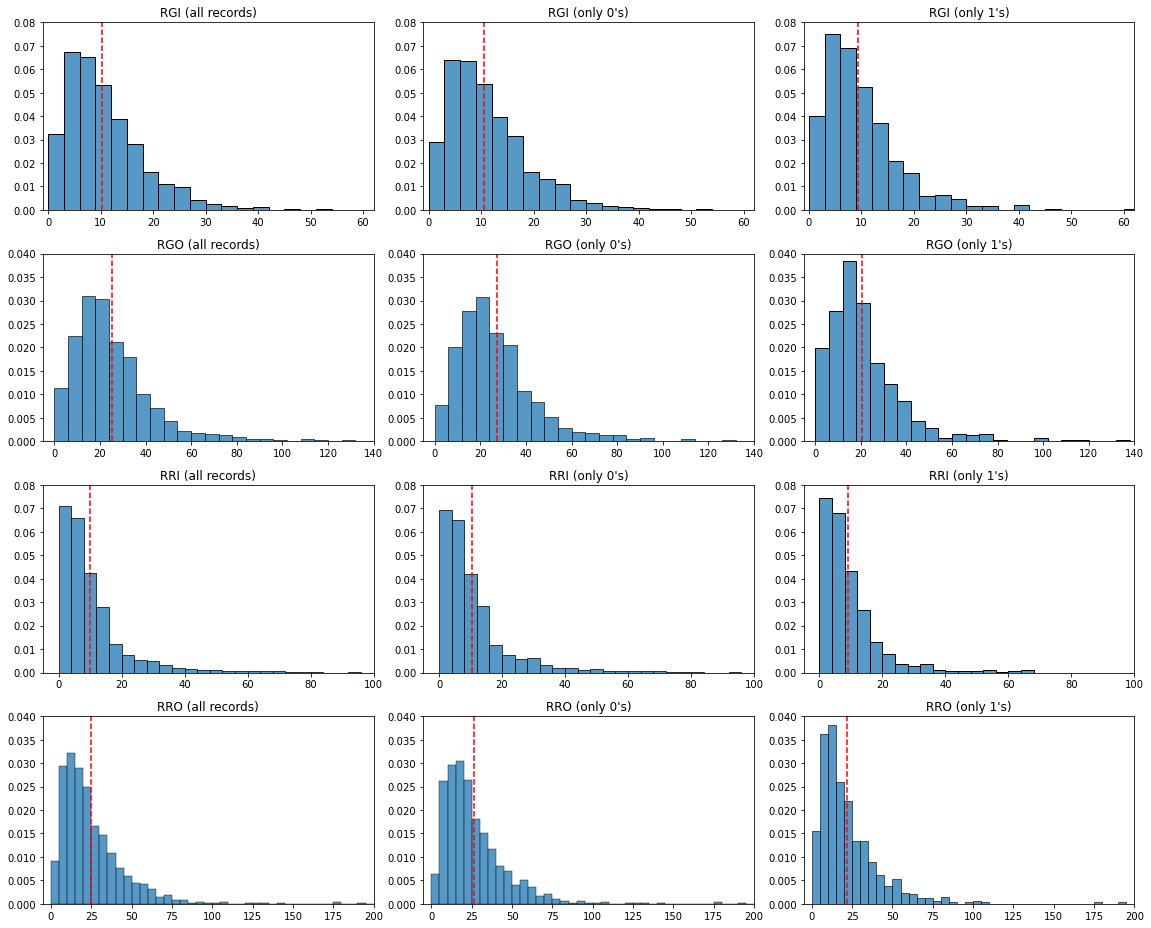

In [56]:
fig, ax = plt.subplots(n_plots, 3, figsize=(16, 13))

datasets = [df_referrals, df_referrals.loc[df_referrals["wont_renew"] == 0], df_referrals.loc[df_referrals["wont_renew"] == 1]]

for i in range(len(datasets)):
    sns.histplot(x="RGI", stat="density", binwidth=3, data=datasets[i], ax=ax[0,i])
    ax[0,i].axvline(datasets[i]["RGI"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="RGO", stat="density", binwidth=6, data=datasets[i], ax=ax[1,i])
    ax[1,i].axvline(datasets[i]["RGO"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="RRI", stat="density", binwidth=4, data=datasets[i], ax=ax[2,i])
    ax[2,i].axvline(datasets[i]["RRI"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="RRO", stat="density", binwidth=5, data=datasets[i], ax=ax[3,i])
    ax[3,i].axvline(datasets[i]["RRO"].mean(), color="red", linestyle="--")
    
    
    # LIMITS
    ax[0,i].set_xlim([-1, 62]) # RGI
    ax[0,i].set_ylim([0, 0.08])
    
    ax[1,i].set_xlim([-5, 140]) # RGO
    ax[1,i].set_ylim([0, 0.04])
    
    ax[2,i].set_xlim([-5, 100]) # RRI
    ax[2,i].set_ylim([0, 0.08])
    
    ax[3,i].set_xlim([-5, 200]) # RRO
    ax[3,i].set_ylim([0, 0.04])

for i in range(n_plots):
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,0].title.set_text(cols[i] + " (all records)")
    
    ax[i,1].set_xlabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].title.set_text(cols[i] + " (only 0's)")
    
    ax[i,2].set_xlabel("")
    ax[i,2].set_ylabel("")
    ax[i,2].title.set_text(cols[i] + " (only 1's)")

plt.tight_layout()
plt.savefig('plots/referrals_density.png', dpi=500, bbox_inches='tight')
plt.show()

They look very similar in distribution.

In [49]:
df_referral_means = pd.concat([df_referrals.mean()[:-1],
                                 pd.pivot_table(df_referrals, columns=['wont_renew'], aggfunc='mean')],axis=1)
df_referral_means.columns = ["all_records", "only 0's", "only 1's"]
df_referral_means.round(2).to_csv("data/latex_means_referrals.csv")
df_referral_means.round(2)

,all_records,only 0's,only 1's
RGI,10.23,10.63,9.32
RGO,25.25,27.28,20.65
RRI,9.98,10.37,9.09
RRO,24.84,26.20,21.77


In [79]:
df.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'chapter_size', 'chapter_retention_rate',
       'chapter_growth_rate', 'seat_popularity_rate', 'total_meetings',
       'wont_renew'],
      dtype='object')

## Final PALMS data columns (columns 13-17)

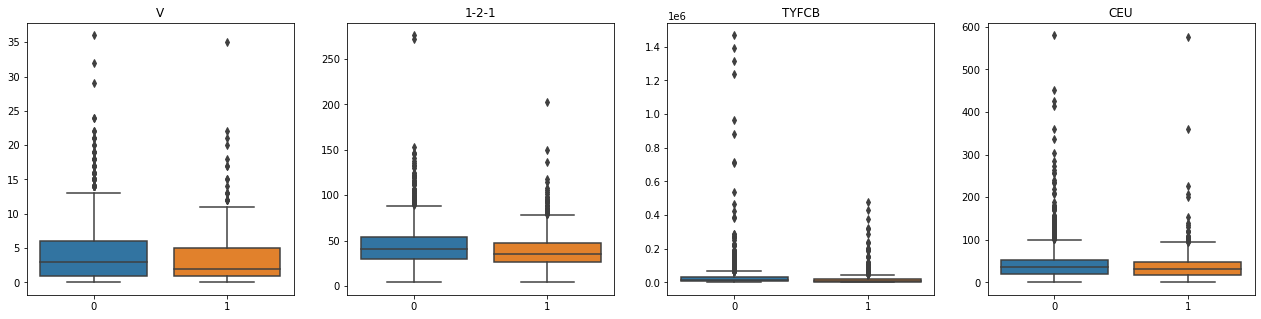

In [57]:
cols = ['V', '1-2-1', 'TYFCB', 'CEU', 'wont_renew']
df_other = df[cols].copy()
n_plots = len(cols) - 1

fig, ax = plt.subplots(1, n_plots, figsize=(22, 5))

for i in range(n_plots):
    sns.boxplot(y=cols[i], x="wont_renew", data=df_other, ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].title.set_text(cols[i])

plt.savefig('plots/other_boxplots.png', dpi=400, bbox_inches='tight')
plt.show()

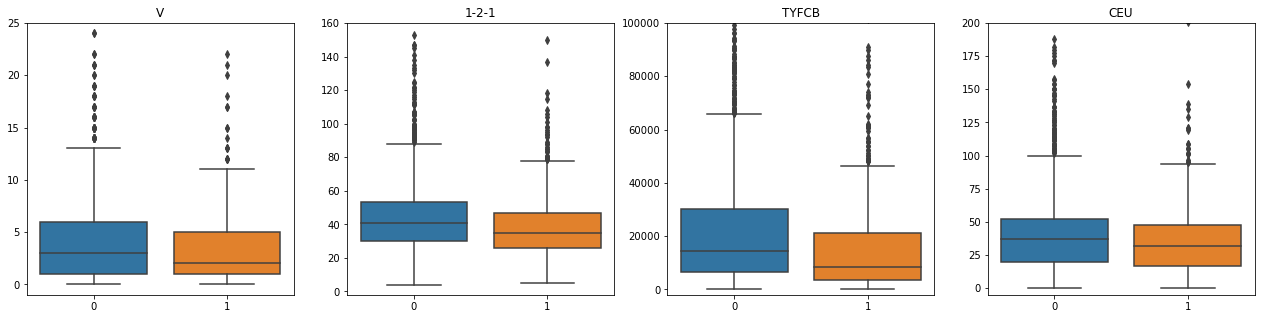

In [58]:
# Zoomed-in boxplots

fig, ax = plt.subplots(1, n_plots, figsize=(22, 5))

for i in range(n_plots):
    sns.boxplot(y=cols[i], x="wont_renew", data=df_other, ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].title.set_text(cols[i])

ax[0].set_ylim([-1, 25])
ax[1].set_ylim([-2, 160])
ax[2].set_ylim([-2000, 100000])
ax[3].set_ylim([-5, 200])

plt.savefig('plots/other_boxplots2.png', dpi=400, bbox_inches='tight')
plt.show()

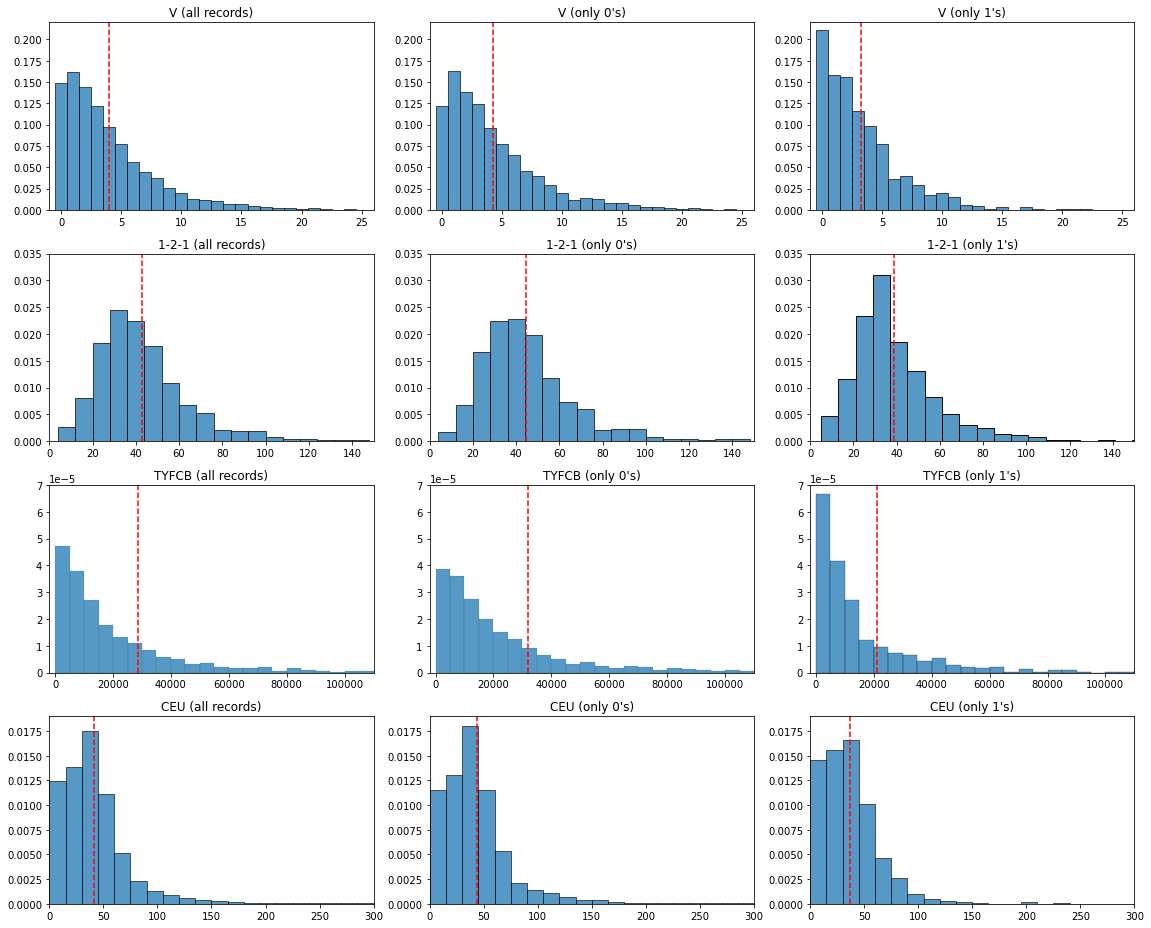

In [59]:
fig, ax = plt.subplots(n_plots, 3, figsize=(16, 13))

datasets = [df_other, df_other.loc[df_other["wont_renew"] == 0], df_other.loc[df_other["wont_renew"] == 1]]

for i in range(len(datasets)):
    sns.histplot(x="V", stat="density", discrete=True, data=datasets[i], ax=ax[0,i])
    ax[0,i].axvline(datasets[i]["V"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="1-2-1", stat="density", binwidth=8, data=datasets[i], ax=ax[1,i])
    ax[1,i].axvline(datasets[i]["1-2-1"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="TYFCB", stat="density", binwidth=5000, data=datasets[i], ax=ax[2,i])
    ax[2,i].axvline(datasets[i]["TYFCB"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="CEU", stat="density", binwidth=15, data=datasets[i], ax=ax[3,i])
    ax[3,i].axvline(datasets[i]["CEU"].mean(), color="red", linestyle="--")
    
    
#     # LIMITS
    ax[0,i].set_xlim([-1, 26]) # V
    ax[0,i].set_ylim([0, 0.22])
    
    ax[1,i].set_xlim([0, 150]) # 1-2-1
    ax[1,i].set_ylim([0, 0.035])
    
    ax[2,i].set_xlim([-2000, 110000]) # TYFCB
    ax[2,i].set_ylim([0, 0.00007])
    
    ax[3,i].set_xlim([0, 300]) # CEU
    ax[3,i].set_ylim([0, 0.019])

for i in range(n_plots):
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,0].title.set_text(cols[i] + " (all records)")
    
    ax[i,1].set_xlabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].title.set_text(cols[i] + " (only 0's)")
    
    ax[i,2].set_xlabel("")
    ax[i,2].set_ylabel("")
    ax[i,2].title.set_text(cols[i] + " (only 1's)")

plt.tight_layout()
plt.savefig('plots/other_density.png', dpi=500, bbox_inches='tight')
plt.show()

In [55]:
df_other_means = pd.concat([df_other.mean()[:-1],
                                 pd.pivot_table(df_other, columns=['wont_renew'], aggfunc='mean')],axis=1)
df_other_means.columns = ["all_records", "only 0's", "only 1's"]
df_other_means.round(2).to_csv("data/latex_means_other.csv")
df_other_means.round(2)

,all_records,only 0's,only 1's
V,3.94,4.24,3.27
1-2-1,42.68,44.46,38.66
TYFCB,28641.12,32045.09,20946.72
CEU,41.40,43.41,36.85


### Extra chapter/seat variables (cols 19-21)

<Figure size 1152x720 with 0 Axes>

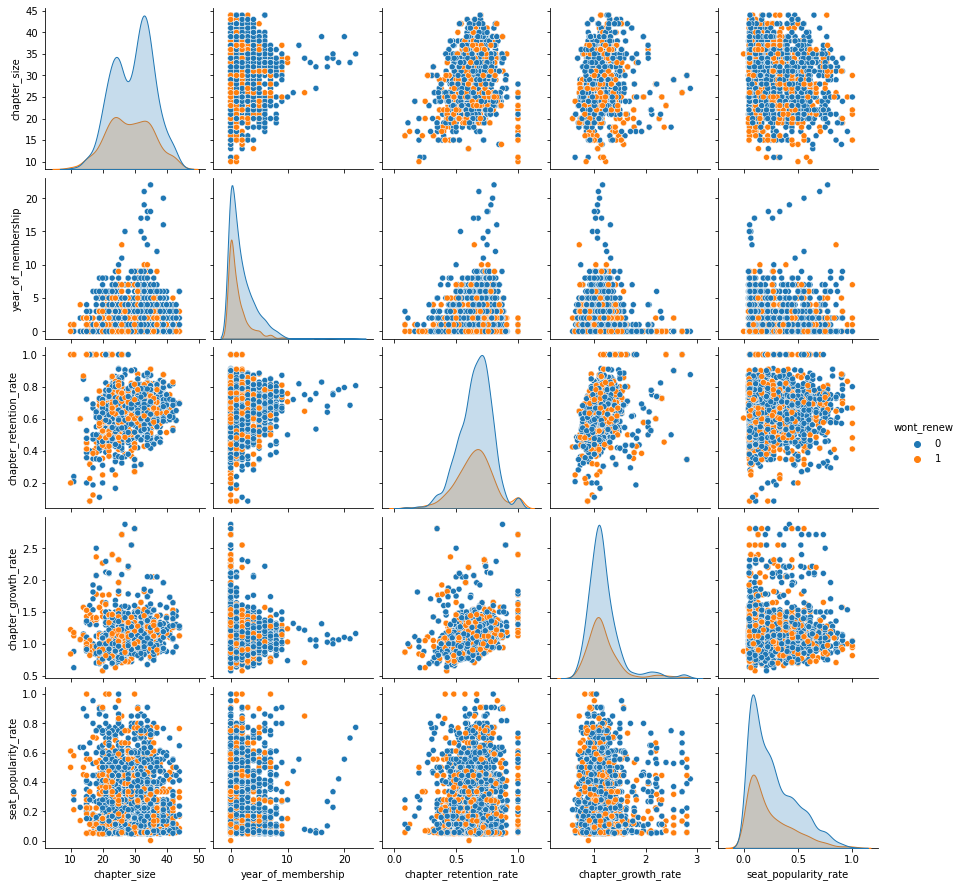

In [61]:
cols = ['chapter_size', 'year_of_membership', 'chapter_retention_rate', 'chapter_growth_rate', 'seat_popularity_rate', 'wont_renew']
df_created = df[cols].copy()
n_plots = len(cols) - 1

plt.figure(figsize=(16, 10))
sns.pairplot(df_created, hue="wont_renew")
# plt.suptitle("Pairplot attendance values")
plt.show()

Interstingly the pairplot shows that the distribution in the kernel density plot on the diagonal has a very similar shape for each of those variables regardless of the fact if someone will be renwing their membership or wont.

One would assume that:
- if a chapters' ```chapter_retention_rate``` was **low** then less members would be willing to renew and the orange density plot would be more **right-skewed**
- if a chapters' ```chapter_retention_rate``` was **high** then more members would be willing to renew and the blue density plot would be more **left-skewed**.

The plot above clearly doesn't show such tendencies though.

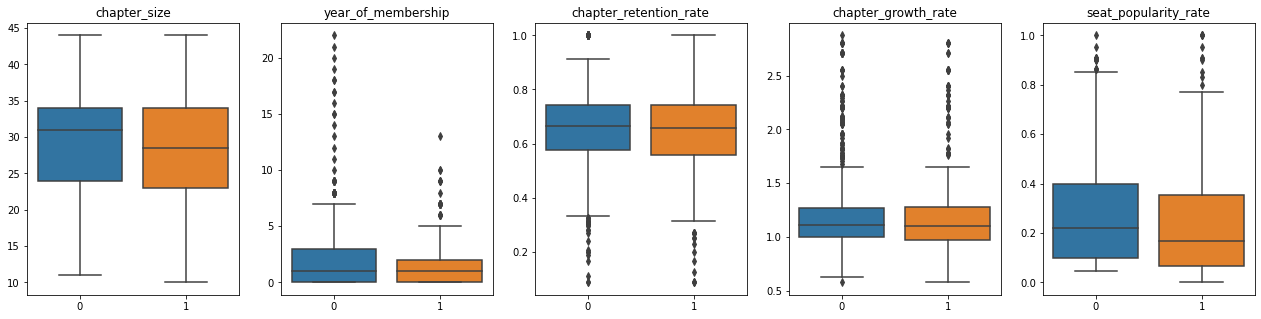

In [62]:
fig, ax = plt.subplots(1, n_plots, figsize=(22, 5))

for i in range(n_plots):
    sns.boxplot(y=cols[i], x="wont_renew", data=df_created, ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].title.set_text(cols[i])
plt.savefig('plots/created_boxplots.png', dpi=400, bbox_inches='tight')
plt.show()

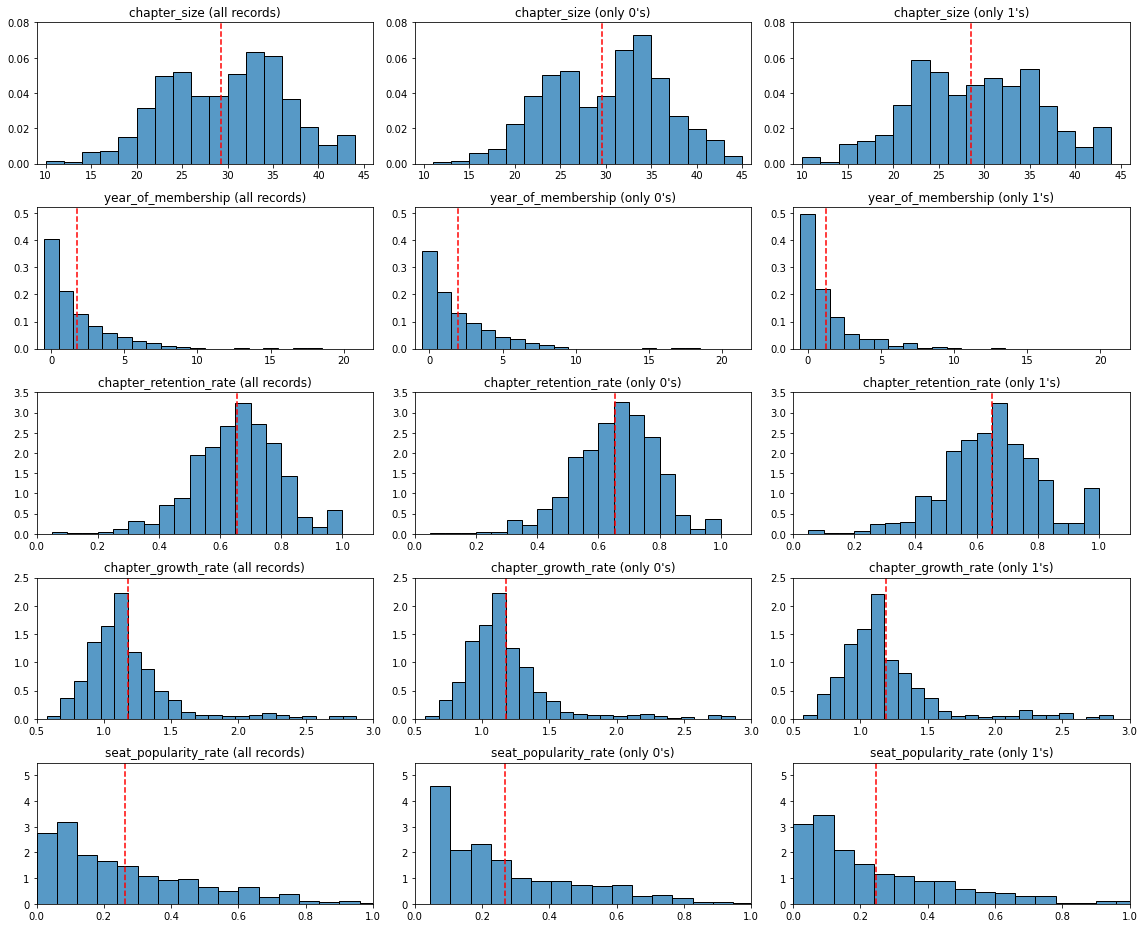

In [63]:
fig, ax = plt.subplots(n_plots, 3, figsize=(16, 13))

datasets = [df_created, df_created.loc[df_created["wont_renew"] == 0], df_created.loc[df_created["wont_renew"] == 1]]

for i in range(len(datasets)):
    sns.histplot(x="chapter_size", stat="density", binwidth=2, data=datasets[i], ax=ax[0,i])
    ax[0,i].axvline(datasets[i]["chapter_size"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="year_of_membership", stat="density", discrete=True, data=datasets[i], ax=ax[1,i])
    ax[1,i].axvline(datasets[i]["year_of_membership"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="chapter_retention_rate", stat="density", bins=np.arange(0, 1.05, 0.05), data=datasets[i], ax=ax[2,i])
    ax[2,i].axvline(datasets[i]["chapter_retention_rate"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="chapter_growth_rate", stat="density", binwidth=0.1, data=datasets[i], ax=ax[3,i])
    ax[3,i].axvline(datasets[i]["chapter_growth_rate"].mean(), color="red", linestyle="--")
    
    sns.histplot(x="seat_popularity_rate", stat="density", binwidth=0.06, data=datasets[i], ax=ax[4,i])
    ax[4,i].axvline(datasets[i]["seat_popularity_rate"].mean(), color="red", linestyle="--")
    
    
    # LIMITS
    ax[0,i].set_xlim([9, 46]) # chapter_size
    ax[0,i].set_ylim([0, 0.08])
    
    ax[1,i].set_xlim([-1, 22]) # year_of_membership
    ax[1,i].set_ylim([0, 0.52])
    
    ax[2,i].set_xlim([0, 1.1]) # chapter_retention_rate
    ax[2,i].set_ylim([0, 3.5])
    
    ax[3,i].set_xlim([0.5, 3]) # chapter_growth_rate
    ax[3,i].set_ylim([0, 2.5])
    
    ax[4,i].set_xlim([0, 1]) # seat_popularity_rate
    ax[4,i].set_ylim([0, 5.5])

for i in range(n_plots):
    ax[i,0].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,0].title.set_text(cols[i] + " (all records)")
    
    ax[i,1].set_xlabel("")
    ax[i,1].set_ylabel("")
    ax[i,1].title.set_text(cols[i] + " (only 0's)")
    
    ax[i,2].set_xlabel("")
    ax[i,2].set_ylabel("")
    ax[i,2].title.set_text(cols[i] + " (only 1's)")

plt.tight_layout()
plt.savefig('plots/created_density.png', dpi=500, bbox_inches='tight')
plt.show()

In [59]:
df_created_means = pd.concat([df_created.mean()[:-1],
                                 pd.pivot_table(df_created, columns=['wont_renew'], aggfunc='mean')],axis=1)
df_created_means.columns = ["all_records", "only 0's", "only 1's"]
df_created_means.round(2).to_csv("data/latex_means_created.csv")
df_created_means.round(2)

,all_records,only 0's,only 1's
chapter_size,29.24,29.56,28.52
year_of_membership,1.75,1.97,1.25
chapter_retention_rate,0.65,0.66,0.65
chapter_growth_rate,1.18,1.18,1.19
seat_popularity_rate,0.26,0.27,0.24


## Additional plots

In [52]:
df2 = df.copy()

df2["P_by_A"] = df2["P"] / (df2["A"] + 1)
df2.columns

Index(['user_ID', 'chapter_ID', 'relative_renewal_date', 'P', 'A', 'L', 'M',
       'S', 'RGI', 'RGO', 'RRI', 'RRO', 'V', '1-2-1', 'TYFCB', 'CEU',
       'year_of_membership', 'chapter_size', 'chapter_retention_rate',
       'chapter_growth_rate', 'seat_popularity_rate', 'total_meetings',
       'wont_renew', 'P_by_A'],
      dtype='object')

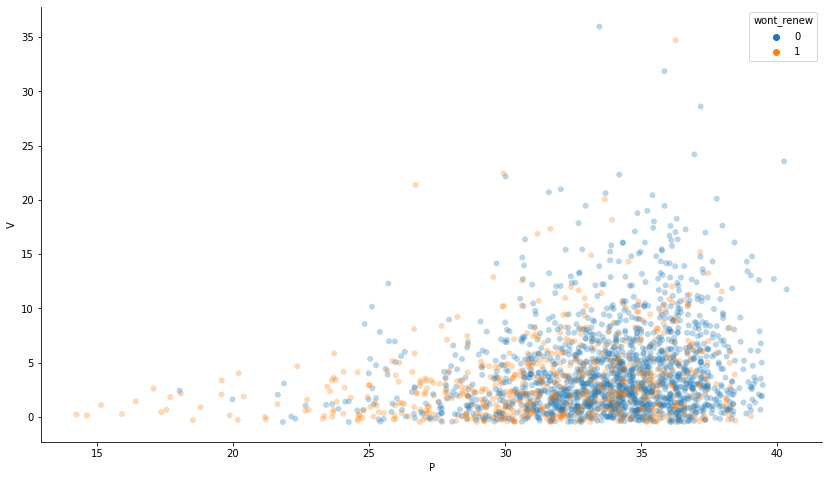

In [62]:
plt.figure(figsize=(14, 8))
scatter_jitter(x="P", y="V", hue="wont_renew", sizes=[6,6], edgecolor='none', alpha=0.3, data=df)
sns.despine()
plt.show()

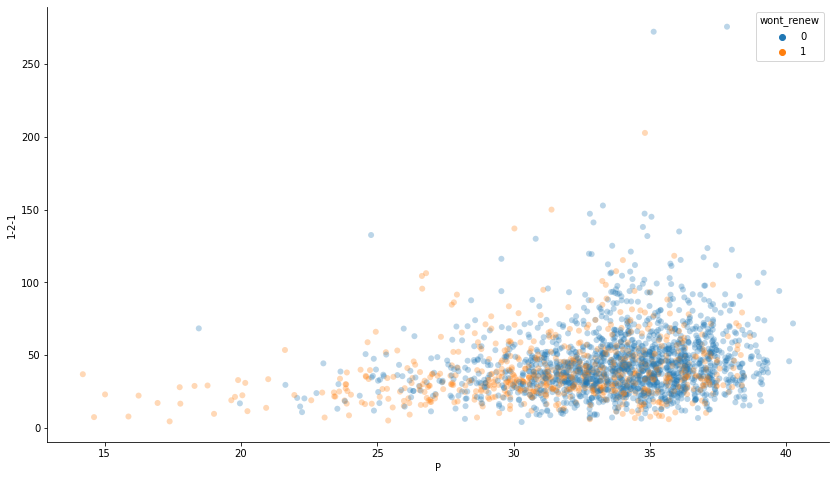

In [63]:
plt.figure(figsize=(14, 8))
scatter_jitter(x="P", y="1-2-1", hue="wont_renew", sizes=[6,6], edgecolor='none', alpha=0.3, data=df)
sns.despine()
plt.show()

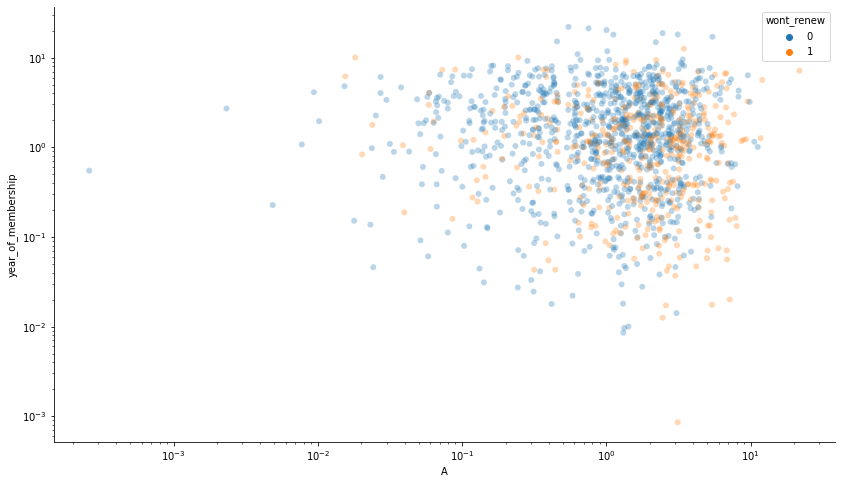

In [67]:
plt.figure(figsize=(14, 8))
scatter_jitter(x="A", y="year_of_membership", hue="wont_renew", sizes=[6,6], edgecolor='none', alpha=0.3, data=df)
sns.despine()
plt.xscale('log')
plt.yscale('log')
plt.show()

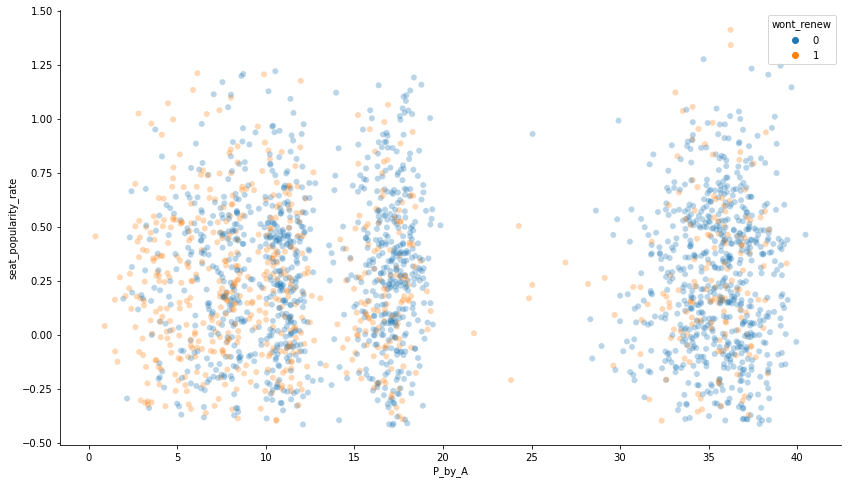

In [54]:
plt.figure(figsize=(14, 8))
scatter_jitter(x="P_by_A", y="seat_popularity_rate", hue="wont_renew", sizes=[5,6], edgecolor='none', alpha=0.3, data=df2)
sns.despine()
plt.show()

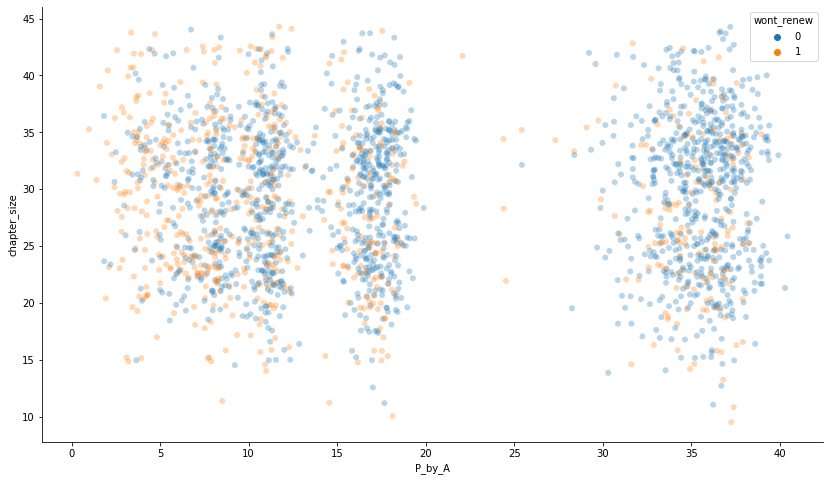

In [56]:
plt.figure(figsize=(14, 8))
scatter_jitter(x="P_by_A", y="chapter_size", hue="wont_renew", sizes=[5,6], edgecolor='none', alpha=0.3, data=df2)
sns.despine()
plt.show()

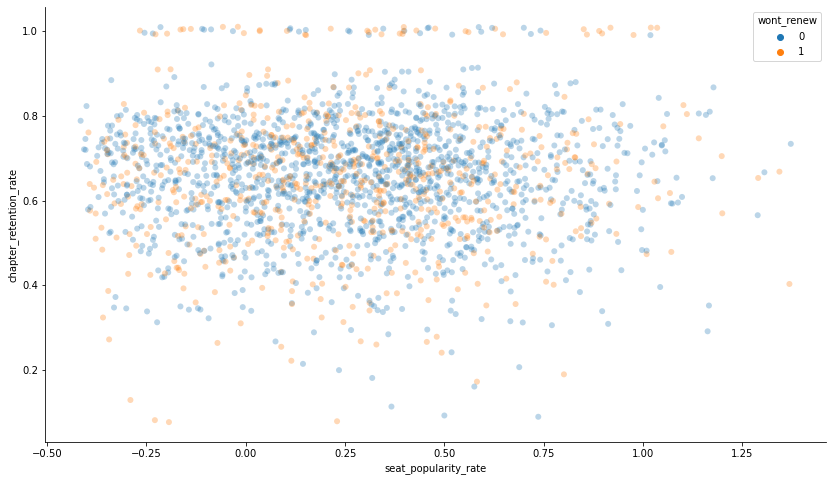

In [64]:
plt.figure(figsize=(14, 8))
scatter_jitter(x="seat_popularity_rate", y="chapter_retention_rate", hue="wont_renew", y_jitter=0.01, sizes=[5,6], edgecolor='none', alpha=0.3, data=df2)
sns.despine()
plt.show()

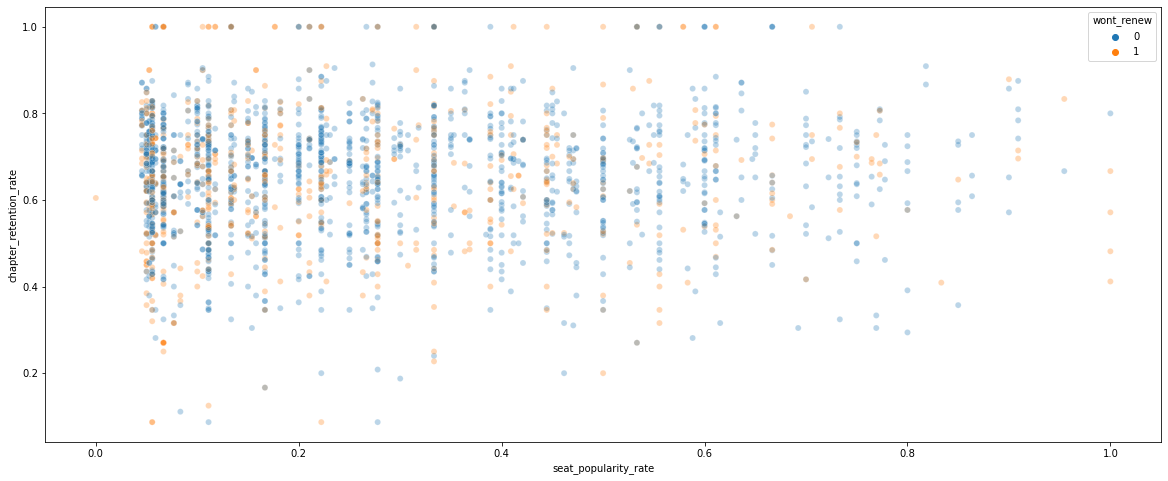

In [58]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x="seat_popularity_rate", y="chapter_retention_rate", hue="wont_renew", alpha=0.3, data=df2)
plt.show()

In [65]:
df.head()

,user_ID,chapter_ID,relative_renewal_date,P,A,L,M,S,RGI,RGO,RRI,RRO,V,1-2-1,TYFCB,CEU,year_of_membership,chapter_size,chapter_retention_rate,chapter_growth_rate,seat_popularity_rate,total_meetings,wont_renew
0,0,31,2016-04-01,33,0,0,1,0,21,7,33,32,1,37,129784,45,0,32,0.315789,1.421053,0.076923,34,0
1,2,18,2017-05-01,33,2,2,0,0,6,17,11,22,1,26,9285,1,0,34,0.718750,1.093750,0.266667,37,0
2,2,18,2018-05-01,35,1,0,0,2,6,24,19,36,1,20,7263,10,1,21,0.424242,0.636364,0.210526,38,0
3,2,18,2019-05-01,36,0,0,0,1,9,8,23,19,3,28,1860,31,2,22,0.739130,1.217391,0.263158,37,0
4,2,18,2020-05-01,33,1,0,0,3,10,13,19,47,4,30,6668,16,3,26,0.760000,1.120000,0.277778,37,0


In [66]:
df.shape

(2191, 23)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 0 to 2428
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_ID                 2191 non-null   int64  
 1   chapter_ID              2191 non-null   int64  
 2   relative_renewal_date   2191 non-null   object 
 3   P                       2191 non-null   int64  
 4   A                       2191 non-null   int64  
 5   L                       2191 non-null   int64  
 6   M                       2191 non-null   int64  
 7   S                       2191 non-null   int64  
 8   RGI                     2191 non-null   int64  
 9   RGO                     2191 non-null   int64  
 10  RRI                     2191 non-null   int64  
 11  RRO                     2191 non-null   int64  
 12  V                       2191 non-null   int64  
 13  1-2-1                   2191 non-null   int64  
 14  TYFCB                   2191 non-null   

In [68]:
df.to_csv("data/df_post_EDA.csv")